# 02 - Parks pro Bezirk

**Ziel:** Ermittelt Parkindikatoren pro Stadtbezirk auf OSM-Basis.

**Inputs:** data/interim/muc_bezirke_bev_clean.geojson, OSM-Parks

**Outputs:** data/processed/muc_bezirke_parks.geojson

**Ausfuehrung:** Von oben nach unten ausfuehren (Restart & Run All). Dieses Notebook ist Teil der Pipeline 00 -> 05.


## Setup

In [2]:
import geopandas as gpd
import osmnx as ox
from pathlib import Path
import matplotlib.pyplot as plt

BASE_DIR = Path("..")
INTERIM_DIR = BASE_DIR / "data" / "interim"
PROCESSED_DIR = BASE_DIR / "data" / "processed"
INTERIM_DIR, PROCESSED_DIR


(PosixPath('../data/interim'), PosixPath('../data/processed'))

## Daten laden

### Bezirk DF laden

In [3]:
gdf_bezirke = gpd.read_file(INTERIM_DIR / "muc_bezirke_bev_clean.geojson")
gdf_bezirke.head()


,bez_nr,name,stadtbezirk,einwohner,flaeche_ha,einwohnerdichte,geometry
0,1,Altstadt-Lehel,Altstadt - Lehel,20876,314.59,66.0,"POLYGON ((692704.77 5336941.154, 692682.921 53..."
1,2,Ludwigsvorstadt-Isarvorstadt,Ludwigsvorstadt - Isarvorstadt,50081,440.17,114.0,"POLYGON ((689722.841 5335359.37, 689570.385 53..."
2,3,Maxvorstadt,Maxvorstadt,52434,429.82,122.0,"POLYGON ((690674.877 5336921.715, 690657.282 5..."
3,4,Schwabing-West,Schwabing West,68610,436.33,157.0,"POLYGON ((691821.837 5339259.125, 691767.291 5..."
4,5,Au-Haidhausen,Au - Haidhausen,63972,422.00,152.0,"POLYGON ((693021.981 5335306.773, 693021.084 5..."


### Parks aus OpenStreetMap laden

In diesem Schritt werden alle OSM-Objekte mit `leisure = "park"` für das Stadtgebiet
München abgefragt und in das gleiche Koordinatensystem wie der Bezirkslayer transformiert.

In [4]:
place_name = "München, Deutschland"
park_tags = {"leisure": "park"}

# Parks aus OSM abfragen
gdf_parks = ox.features_from_place(place_name, park_tags)

# CRS an Bezirkslayer anpassen
gdf_parks = gdf_parks.to_crs(gdf_bezirke.crs)

gdf_parks[["name", "geometry"]].head()
len(gdf_parks)


954

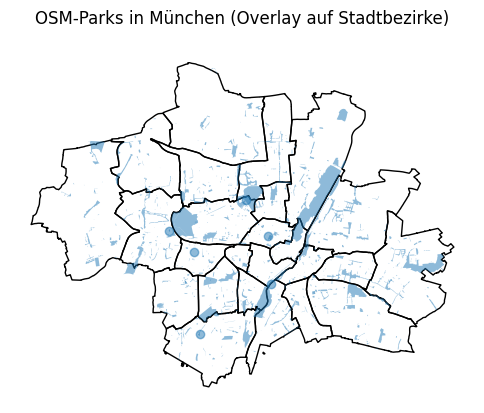

In [7]:
# Visualisierung der Parks über den Stadtbezirken
ax = gdf_bezirke.plot(edgecolor="black", facecolor="none", figsize=(6, 6))
gdf_parks.plot(ax=ax, alpha=0.5)
plt.title("OSM-Parks in München (Overlay auf Stadtbezirke)")
plt.axis("off")
plt.show()


## Preparation

### Räumliche Zuordnung der Parks zu Stadtbezirken

Mittels `gpd.sjoin` werden die Parkgeometrien den Stadtbezirken zugeordnet, sodass
jeder Park eine Bezirksnummer (`bez_nr`) erhält.

In [8]:
# Nur Park-Name und Geometrie behalten
parks = gdf_parks[["name", "geometry"]].copy()

# Räumlicher Join: welcher Park fällt in welchen Bezirk?
parks_in_bezirke = gpd.sjoin(
    parks,
    gdf_bezirke[["bez_nr", "geometry"]],
    how="inner",
    predicate="intersects"
)

parks_in_bezirke[["name", "bez_nr"]].head(10)


name  \
element  id                                                               
node     5141107389                                         Rosengarten   
         6521903324                   Gemeinschaftsgarten o'pflanzt is!   
         9127973599                                          Hühnerberg   
         10315621109                                       Laimer Anger   
         12357383401  Garten der Städtischen Galerie im Lenbachhaus ...   
         13167237558                                                NaN   
relation 29600                                            Weißenseepark   
         117906                                      Hinterbrühler Park   
         146438                                                     NaN   
         151288                                                     NaN   

                      bez_nr  
element  id                   
node     5141107389       18  
         6521903324        9  
         9127973599       19  
         10315621109      25  
         12357383401       3  
         13167237558      21  
relation 29600            17  
         117906           19  
         146438           15  
         151288           21

### Aggregation auf Bezirksebene & Ableitung von Park-Kennzahlen

In [9]:
# Anzahl Parks je Bezirk
parks_per_bez = (
    parks_in_bezirke
    .groupby("bez_nr")
    .size()
    .reset_index(name="parks_count")
)


# Parkfläche je Bezirk (Fläche der Parkgeometrie)
parks_in_bezirke["park_area"] = parks_in_bezirke.geometry.area

parks_area_per_bez = (
    parks_in_bezirke
    .groupby("bez_nr")["park_area"]
    .sum()
    .reset_index()
)


# In Hektar (ha) umrechnen (wenn CRS in Meter -> m²)
parks_area_per_bez["parks_area_ha"] = parks_area_per_bez["park_area"] / 10_000
parks_area_per_bez = parks_area_per_bez[["bez_nr", "parks_area_ha"]]


In [10]:
# Mit Bezirksdaten zusammenführen
gdf_active = gdf_bezirke.merge(parks_per_bez, on="bez_nr", how="left")
gdf_active = gdf_active.merge(parks_area_per_bez, on="bez_nr", how="left")

# Bezirke ohne Parks auf 0 setzen
gdf_active[["parks_count", "parks_area_ha"]] = gdf_active[["parks_count", "parks_area_ha"]].fillna(0)

# Ableitung der Kennzahlen
gdf_active["parks_pro_1000_einw"] = gdf_active["parks_count"] / gdf_active["einwohner"] * 1000
gdf_active["parks_area_ha_pro_1000_einw"] = gdf_active["parks_area_ha"] / gdf_active["einwohner"] * 1000
gdf_active["parks_area_anteil_prozent"] = gdf_active["parks_area_ha"] / gdf_active["flaeche_ha"] * 100

# Ergebnis anschauen
gdf_active[["bez_nr", "name", "parks_count", "parks_area_ha","parks_pro_1000_einw", "parks_area_anteil_prozent"]].head(30)


,bez_nr,name,parks_count,parks_area_ha,parks_pro_1000_einw,parks_area_anteil_prozent
0,1,Altstadt-Lehel,27,412.764810,1.293351,131.207225
1,2,Ludwigsvorstadt-Isarvorstadt,21,158.267122,0.419321,35.955908
2,3,Maxvorstadt,35,424.167862,0.667506,98.684999
3,4,Schwabing-West,23,177.474001,0.335228,40.674260
4,5,Au-Haidhausen,36,82.649221,0.562746,19.585124
5,6,Sendling,19,160.100229,0.463392,40.645924
6,7,Sendling-Westpark,35,142.506423,0.562339,18.235220
7,8,Schwanthalerhöhe,10,13.358433,0.348626,6.452414
8,9,Neuhausen-Nymphenburg,76,433.357830,0.745822,33.554873
9,10,Moosach,45,77.851084,0.803356,7.017594


## Analyse der Kennzahlen

In [12]:
gdf_active[["bez_nr", "name", "parks_count", "parks_area_ha","parks_pro_1000_einw", "parks_area_anteil_prozent"]].head(30)

,bez_nr,name,parks_count,parks_area_ha,parks_pro_1000_einw,parks_area_anteil_prozent
0,1,Altstadt-Lehel,27,412.764810,1.293351,131.207225
1,2,Ludwigsvorstadt-Isarvorstadt,21,158.267122,0.419321,35.955908
2,3,Maxvorstadt,35,424.167862,0.667506,98.684999
3,4,Schwabing-West,23,177.474001,0.335228,40.674260
4,5,Au-Haidhausen,36,82.649221,0.562746,19.585124
5,6,Sendling,19,160.100229,0.463392,40.645924
6,7,Sendling-Westpark,35,142.506423,0.562339,18.235220
7,8,Schwanthalerhöhe,10,13.358433,0.348626,6.452414
8,9,Neuhausen-Nymphenburg,76,433.357830,0.745822,33.554873
9,10,Moosach,45,77.851084,0.803356,7.017594


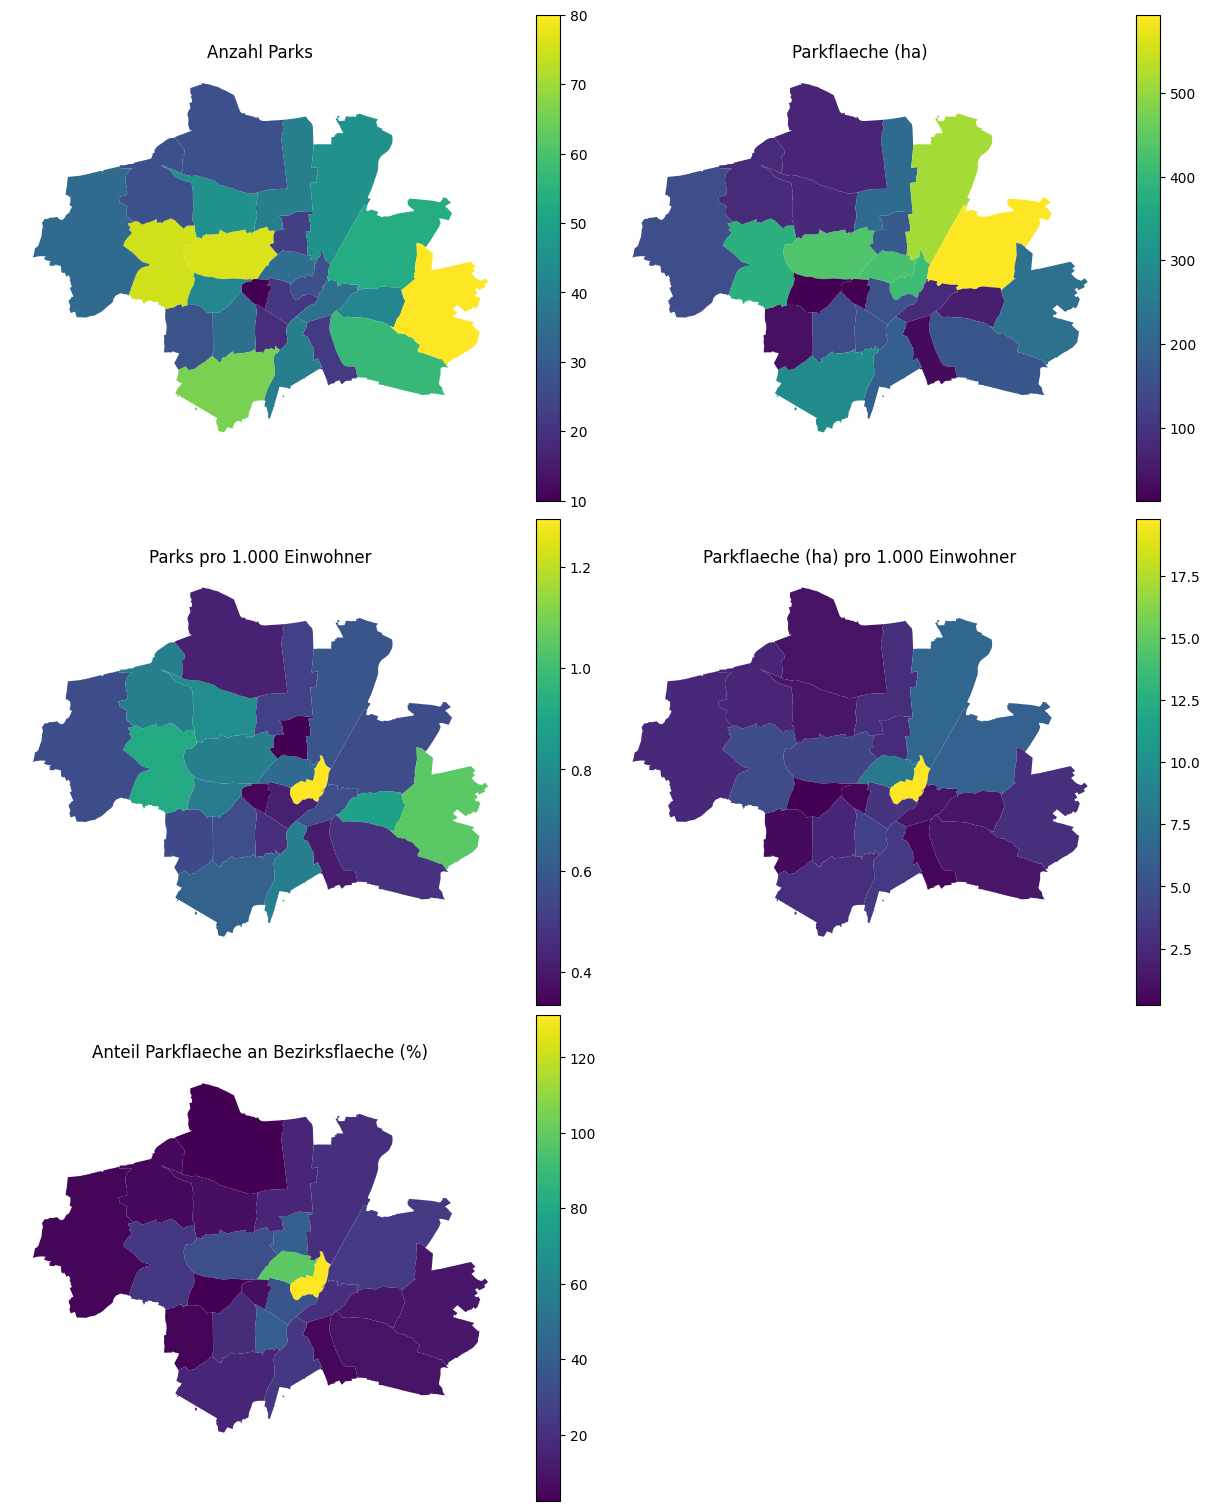

In [14]:
# Choroplethenkarten fuer alle zentralen Park-Kennzahlen
park_map_cols = [
    ("parks_count", "Anzahl Parks"),
    ("parks_area_ha", "Parkflaeche (ha)"),
    ("parks_pro_1000_einw", "Parks pro 1.000 Einwohner"),
    ("parks_area_ha_pro_1000_einw", "Parkflaeche (ha) pro 1.000 Einwohner"),
    ("parks_area_anteil_prozent", "Anteil Parkflaeche an Bezirksflaeche (%)"),
]

available = [(col, title) for col, title in park_map_cols if col in gdf_active.columns]

n = len(available)
if n == 0:
    print("Keine Park-Kennzahlen fuer Karten gefunden.")
else:
    ncols = 2
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 5 * nrows), constrained_layout=True)
    axes = axes.ravel() if hasattr(axes, "ravel") else [axes]

    for ax, (col, title) in zip(axes, available):
        gdf_active.plot(column=col, legend=True, ax=ax)
        ax.set_title(title)
        ax.axis("off")

    for ax in axes[len(available):]:
        ax.axis("off")

    plt.show()


### Parks pro 1.000 Einwohner - Histogramm & Boxplot

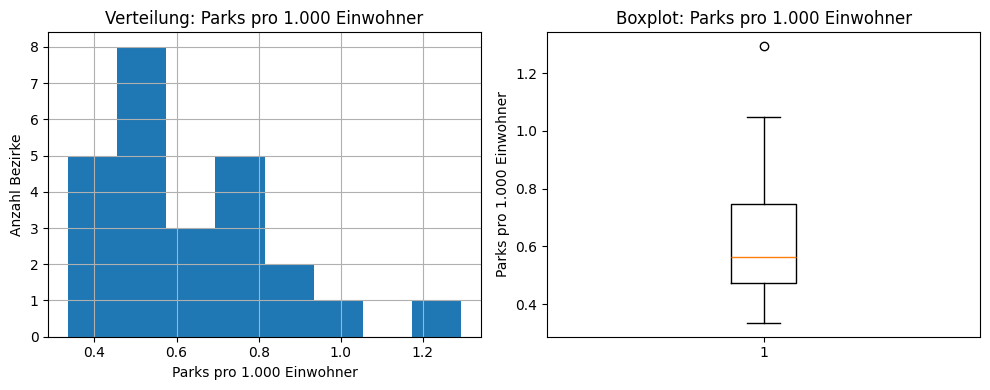

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Histogramm
gdf_active["parks_pro_1000_einw"].hist(ax=axes[0], bins=8)
axes[0].set_title("Verteilung: Parks pro 1.000 Einwohner")
axes[0].set_xlabel("Parks pro 1.000 Einwohner")
axes[0].set_ylabel("Anzahl Bezirke")

# Boxplot
axes[1].boxplot(gdf_active["parks_pro_1000_einw"], vert=True)
axes[1].set_title("Boxplot: Parks pro 1.000 Einwohner")
axes[1].set_ylabel("Parks pro 1.000 Einwohner")

plt.tight_layout()
plt.show()


**Interpretation:**

- Die meisten Stadtbezirke liegen in einem Korridor von etwa *0,4 bis 0,9* Parks pro 1.000 Einwohner.
- Einzelne Bezirke erreichen deutlich höhere Werte (oberes Ende des Boxplots) und sind damit im Vergleich überdurchschnittlich gut mit Parks je Einwohner versorgt.
- Es gibt auch Bezirke am unteren Rand der Verteilung, in denen deutlich weniger Parks pro Einwohner zur Verfügung stehen.


### Anteil der Parkfläche an der Bezirksfläche

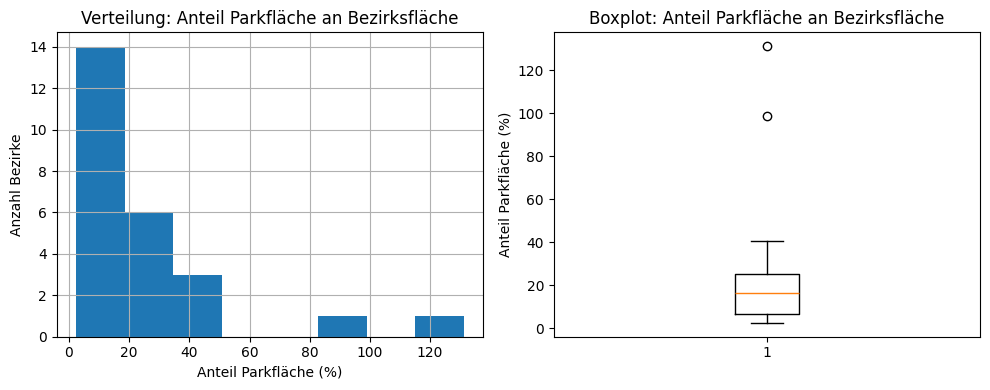

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Histogramm
gdf_active["parks_area_anteil_prozent"].hist(ax=axes[0], bins=8)
axes[0].set_title("Verteilung: Anteil Parkfläche an Bezirksfläche")
axes[0].set_xlabel("Anteil Parkfläche (%)")
axes[0].set_ylabel("Anzahl Bezirke")

# Boxplot
axes[1].boxplot(gdf_active["parks_area_anteil_prozent"], vert=True)
axes[1].set_title("Boxplot: Anteil Parkfläche an Bezirksfläche")
axes[1].set_ylabel("Anteil Parkfläche (%)")

plt.tight_layout()
plt.show()


**Interpretation:**

- Der prozentuale Anteil der Parkfläche an der Bezirksfläche ist insgesamt relativ niedrig und streut nur in einem begrenzten Bereich.
- Einige Bezirke weisen leicht erhöhte Anteile auf (obere Whisker im Boxplot), während andere Bezirke kaum Parkfläche im Verhältnis zur Gesamtfläche besitzen.
- In Kombination mit der Einwohnerdichte lässt sich später untersuchen, ob Bezirke mit dichter Bebauung kompensierend einen höheren Parkflächenanteil aufweisen.


### Ranking: Top- und Bottom-Bezirke

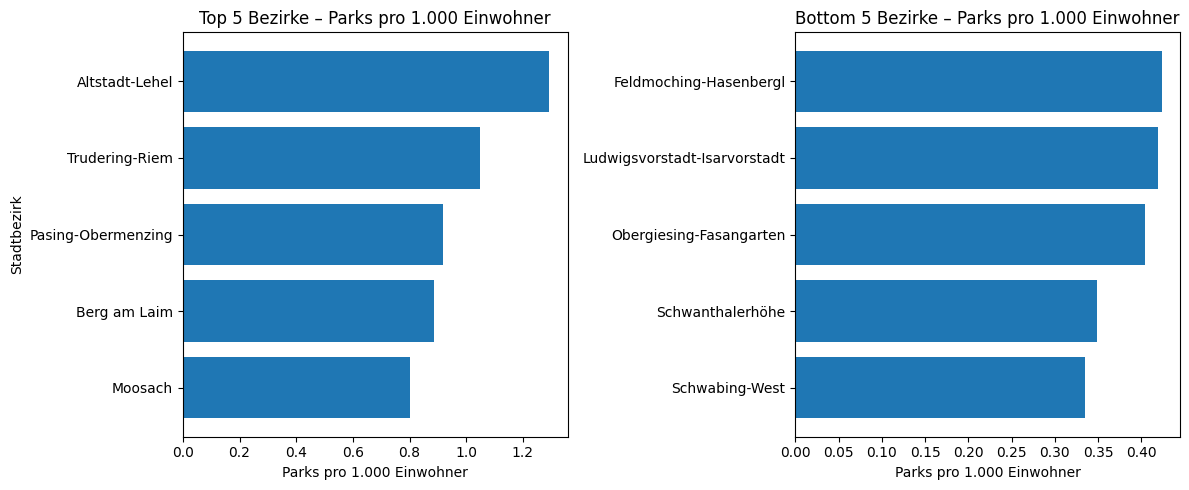

In [17]:
# Neu sortieren, damit es bei barh "von unten nach oben" logisch aussieht
top5 = (
    gdf_active[["name", "parks_pro_1000_einw"]]
    .sort_values("parks_pro_1000_einw", ascending=False)
    .head(5)
    .sort_values("parks_pro_1000_einw", ascending=True)   # für schöne Treppe bei barh
)

bottom5 = (
    gdf_active[["name", "parks_pro_1000_einw"]]
    .sort_values("parks_pro_1000_einw", ascending=True)
    .head(5)
    .sort_values("parks_pro_1000_einw", ascending=True)
)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Top 5 (horizontal)
axes[0].barh(top5["name"], top5["parks_pro_1000_einw"])
axes[0].set_title("Top 5 Bezirke – Parks pro 1.000 Einwohner")
axes[0].set_xlabel("Parks pro 1.000 Einwohner")
axes[0].set_ylabel("Stadtbezirk")

# Bottom 5 (horizontal)
axes[1].barh(bottom5["name"], bottom5["parks_pro_1000_einw"])
axes[1].set_title("Bottom 5 Bezirke – Parks pro 1.000 Einwohner")
axes[1].set_xlabel("Parks pro 1.000 Einwohner")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


**Interpretation:**

- Die Top-5-Bezirke weisen rund *x–y* Parks pro 1.000 Einwohner auf und liegen damit deutlich über dem Mittelwert.
- Die Bottom-5-Bezirke erreichen deutlich geringere Werte; hier stehen den Einwohnerinnen und Einwohnern vergleichsweise wenig Parks pro Kopf zur Verfügung.
- Für die weitere Analyse sind insbesondere Kontrastpaare interessant (z. B. dicht besiedelte Bezirke mit gleichzeitig niedriger Parkausstattung).


## Export des erweiterten Datensatzes

Der Datensatz mit den parkbezogenen Kennzahlen wird für weitere Analysen
als GeoJSON-Datei abgelegt.

In [18]:
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
out_path = PROCESSED_DIR / "muc_bezirke_parks.geojson"
gdf_active.to_file(out_path, driver="GeoJSON")
out_path


PosixPath('../data/processed/muc_bezirke_parks.geojson')